In [1]:
from keras.models import Sequential  
from keras.layers.core import Dense, Activation
from keras.layers.recurrent import LSTM
from keras.layers import Flatten
from keras.layers import Embedding

Using TensorFlow backend.


In [2]:
import tensorflow as tf
print(tf.test.gpu_device_name())

In [28]:
# !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
# !add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
# !apt-get update -qq 2>&1 > /dev/null
# !apt-get -y install -qq google-drive-ocamlfuse fuse
# from google.colab import auth
# auth.authenticate_user()
# from oauth2client.client import GoogleCredentials
# creds = GoogleCredentials.get_application_default()
# import getpass
# !google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
# vcode = getpass.getpass()
# !echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [29]:
# !mkdir -p drive
# !google-drive-ocamlfuse drive

In [30]:
# !ls drive/Project/Transparency\ Text\ Classification

# import os
# os.chdir('./drive/Colab Notebooks/text-classification-transparency')

In [31]:
# !ls

In [3]:
import numpy as np

seed = 42
np.random.seed(seed)

In [4]:
# from google.colab import files

# uploaded = files.upload()

# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded[fn])))

In [3]:
# Load data

def load_list(filename):
    vocabulary = []
    with open(filename, 'r') as f:
        for l in f:
            vocabulary.append(l.strip())
    return np.asarray(vocabulary)

def load_csv(filename):
    import csv
    
    sentence = []
    with open(filename, 'r') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            sentence.append(str(row))
    return np.asarray(sentence).flatten()

def generate_token_sequence(X_corpus, word_dict, token):
    import re

    token_pattern = re.compile(token)
    X = []
    i=0
    for sentence in X_corpus:
        split = token_pattern.findall(sentence)
        seq = []
        for word in split:
            try:
                seq.append(word_dict[word])
            except KeyError:
                continue
        X.append(seq)

    return np.asarray(X) 

In [39]:
import numpy as np
  
# print('load data...')
# pos_related = load_csv('pos_related.csv')
# neg_related = load_csv('neg_related.csv')
# pos_unrelated = load_csv('pos_unrelated.csv')
# neg_unrelated = load_csv('neg_unrelated.csv')
  
# print(pos_related.shape)
# print(neg_related.shape)
# print(pos_unrelated.shape)
# print(neg_unrelated.shape)
  
# print('Stack the data...')

# related_set = np.hstack((pos_related, neg_related))
# y_related = np.ones(related_set.shape)

# unrelated_set = np.hstack((pos_unrelated, neg_unrelated))
# y_unrelated = np.zeros(unrelated_set.shape)
  
# print('[related, unrelated] : [%d, %d]' %(y_related.shape[0], y_unrelated.shape[0])) 
  
# X_stack = np.hstack((related_set, unrelated_set))
# y_stack = np.hstack((y_related, y_unrelated))

# print('Total data :', len(X_stack))
# print('Split train-test data...')
# import numpy as np
# import random

# random.seed(42)
# param = 2/3
# partition = int(len(X_stack) * param)
# indices = random.sample(range(len(X_stack)),partition)

# X_train_corpus = np.asarray(X_stack[indices])
# X_test_corpus = np.asarray(np.delete(X_stack,indices))
# y_train = y_stack[indices]
# y_test = np.delete(y_stack, indices)

# Clean the special characters
# for i in range(len(X_train_corpus)):
#   X_train_corpus[i] = re.sub('[^A-Za-z0-9 ]+', '', X_train_corpus[i])
# for i in range(len(X_test_corpus)):
#   X_test_corpus[i] = re.sub('[^A-Za-z0-9 ]+', '', X_test_corpus[i])
  
import pickle
def save_pickle(path, X):
    with open(path, 'wb') as f:
        pickle.dump(X, f)
def open_pickle(path):
    with open(path, 'rb') as f:
        X = pickle.load(f)
    return X

X_train_sent = open_pickle("./sentence_data/imdb_sentence_xtrain.pickle")
X_test_sent = open_pickle("./sentence_data/imdb_sentence_xtest.pickle")
y_train = open_pickle("./sentence_data/imdb_sentence_ytrain.pickle")
y_test = open_pickle("./sentence_data/imdb_sentence_ytest.pickle")

print('Train : ',len(X_train_sent))
print('Test : ', len(X_test_sent))
  
from sklearn.feature_extraction.text import CountVectorizer

token = r"(?u)\b[\w\'/]+\b"
tf_vectorizer = CountVectorizer(lowercase=True, max_df=1.0, min_df=1, binary=False, token_pattern=token)
tf_vectorizer.set_params(ngram_range=(1,1))

tf_vectorizer.fit(X_train_sent)

word_dict = tf_vectorizer.vocabulary_
dict_len = len(tf_vectorizer.get_feature_names())
word_feature = tf_vectorizer.get_feature_names()
  
print('Words :', len(tf_vectorizer.get_feature_names()))
  
print('Generate token sequence...')
X_train = generate_token_sequence(X_train_sent, word_dict, token)
X_test = generate_token_sequence(X_test_sent, word_dict, token)

del X_train_sent
del X_test_sent

from keras.preprocessing.sequence import pad_sequences

print('Generate pad sequences...')
print('Pad sequences (samples x time)')

maxlen=50
x_train = pad_sequences(X_train, maxlen=maxlen, padding='pre', truncating='pre', value=0)
x_test = pad_sequences(X_test, maxlen=maxlen, padding='pre', truncating='pre', value=0)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

del X_train
del X_test

print('Generate one hot')

def generate_one_hot(X):
    X_one_hot = []
  
    for sent in X:
        sent_reverse = []
        for idx in sent:
            sent_reverse.append(word_feature[idx])
        sent_transform = tf_vectorizer.transform(sent_reverse).todense()
        X_one_hot.append(sent_transform)
        del sent_transform
    return np.array(X_one_hot)

X_train_hot = generate_one_hot(x_train)
print('X_train one hot done...')
del x_train
X_test_hot = generate_one_hot(x_test)
print('X_test one hot done...')
del x_test

Train :  1333
Test :  667
Words : 4532
Generate token sequence...
Generate pad sequences...
Pad sequences (samples x time)
x_train shape: (1333, 50)
x_test shape: (667, 50)
Generate one hot
X_train one hot done...
X_test one hot done...


In [40]:
# X_test_hot = generate_one_hot(x_test)
print(X_train_hot.shape)
print(X_test_hot.shape)

(1333, 50, 4532)
(667, 50, 4532)


In [79]:
# !cat /proc/meminfo

In [81]:
import pickle

def save_pickle(path, X):
    with open(path, 'wb') as f:
        pickle.dump(X, f)
def open_pickle(path):
    with open(path, 'rb') as f:
        X = pickle.load(f)
    return X
  
# save_pickle("./imdb_sentence_xtrain.pickle", X_train_corpus)
# save_pickle("./imdb_sentence_xtest.pickle", X_test_corpus)
# save_pickle("./imdb_sentence_ytrain.pickle", y_train)
# save_pickle("./imdb_sentence_ytest.pickle", y_test)

In [43]:
# Split validation and test set

# x_val = np.asarray(x_test[:int(x_test.shape[0]/2)])
# y_val = np.asarray(y_test[:int(len(y_test)/2)])
# x_te = np.asarray(x_test[int(x_test.shape[0]/2):])
# y_te = np.asarray(y_test[int(len(y_test)/2):])

# print(x_val.shape)
# print(x_te.shape)

In [41]:
from keras.callbacks import ModelCheckpoint

# checkpointer = ModelCheckpoint(filepath='./weights_embed_10.hdf5', verbose=1, save_best_only=False)
import numpy as np
import os
import random as rn

seed = 42
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = '0'
rn.seed(42)

session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
from keras import backend as K
tf.set_random_seed(42)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)

K.set_session(sess) 


hidden_neurons = 3
print('Build model...')
model = Sequential()
# model.add(Embedding(dict_len, 100))
model.add(LSTM(output_dim=hidden_neurons, input_dim=dict_len, activation='tanh', recurrent_activation='tanh'))
model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])  
print(model.summary())

Build model...


C:\Users\Anneke\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
C:\Users\Anneke\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(activation="tanh", recurrent_activation="tanh", input_shape=(None, 453..., units=3)`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 3)                 54432     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 4         
Total params: 54,436
Trainable params: 54,436
Non-trainable params: 0
_________________________________________________________________
None


In [42]:
print('Train...')
# hist = model.fit(x_train, y_train, epochs=50, verbose=1, validation_data=(x_val,y_val), shuffle=False, callbacks=[checkpointer])
hist = model.fit(X_train_hot, y_train, epochs=50, verbose=1, validation_data=(X_test_hot,y_test), shuffle=False)

Train...
Train on 1333 samples, validate on 667 samples
Epoch 1/50
1333/1333 [==============================] - 23s 17ms/step - loss: 0.6931 - acc: 0.4989 - val_loss: 0.6935 - val_acc: 0.4558
Epoch 2/50
1333/1333 [==============================] - 18s 14ms/step - loss: 0.6929 - acc: 0.5221 - val_loss: 0.6939 - val_acc: 0.4558
Epoch 3/50
1333/1333 [==============================] - 18s 14ms/step - loss: 0.6926 - acc: 0.5221 - val_loss: 0.6943 - val_acc: 0.4558
Epoch 4/50
1333/1333 [==============================] - 18s 13ms/step - loss: 0.6881 - acc: 0.5221 - val_loss: 0.6981 - val_acc: 0.4558
Epoch 5/50
1333/1333 [==============================] - 18s 13ms/step - loss: 0.6757 - acc: 0.5221 - val_loss: 0.6995 - val_acc: 0.4558
Epoch 6/50
1333/1333 [==============================] - 18s 13ms/step - loss: 0.6560 - acc: 0.5221 - val_loss: 0.6856 - val_acc: 0.4558
Epoch 7/50
1333/1333 [==============================] - 18s 13ms/step - loss: 0.6233 - acc: 0.5386 - val_loss: 0.6637 - val_acc:

### maxlen = 100

Predict...
Predict completed...
--Accuracy--
Train:	0.52588 
Test:	0.45577 
             precision    recall  f1-score   support

        0.0       0.00      0.00      0.00       363
        1.0       0.46      1.00      0.63       304

avg / total       0.21      0.46      0.29       667

--epoch on val loss--
42
0.547266699117
--acc--
0.770614693458


C:\Users\Anneke\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


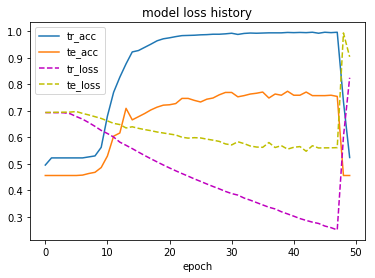

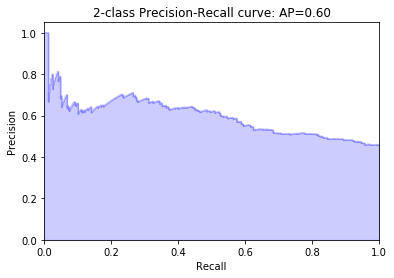

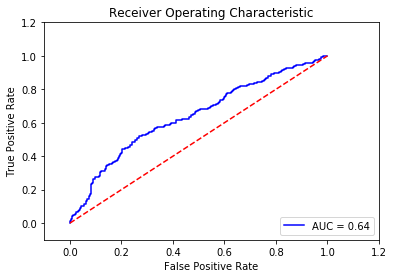

In [26]:
# 1 hidden unit
# tanh activation
# maxlen=100

model_plot(model, X_train_hot, y_train, X_test_hot, y_test)

Predict...
Predict completed...
--Accuracy--
Train:	1.00000 
Test:	0.63568 
             precision    recall  f1-score   support

        0.0       0.78      0.46      0.58       363
        1.0       0.57      0.85      0.68       304

avg / total       0.68      0.64      0.62       667

--epoch on val loss--
22
0.618481694401
--acc--
0.637181408804


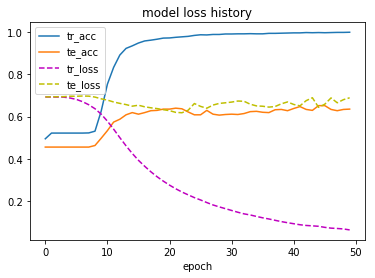

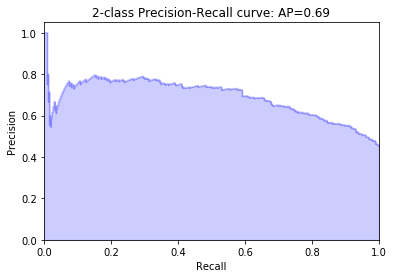

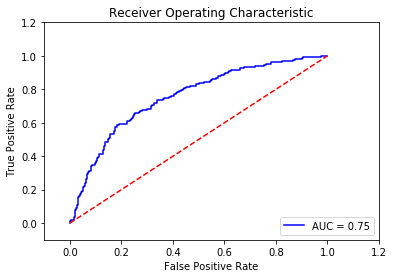

In [32]:
# 2 hidden unit
# tanh activation
# maxlen=100

model_plot(model, X_train_hot, y_train, X_test_hot, y_test)

Predict...
Predict completed...
--Accuracy--
Train:	0.99925 
Test:	0.73913 
             precision    recall  f1-score   support

        0.0       0.84      0.64      0.73       363
        1.0       0.67      0.85      0.75       304

avg / total       0.76      0.74      0.74       667

--epoch on val loss--
19
0.540870604576
--acc--
0.787106447313


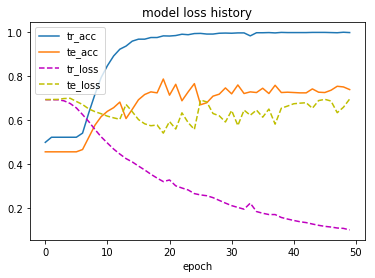

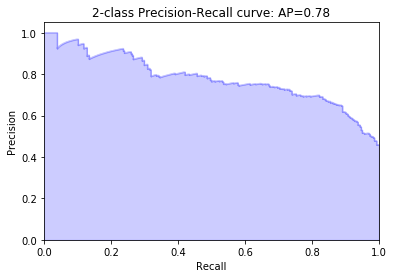

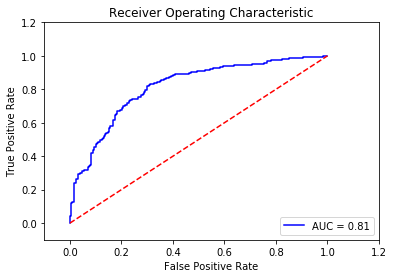

In [35]:
# 3 hidden unit
# tanh activation
# maxlen=100

model_plot(model, X_train_hot, y_train, X_test_hot, y_test)

Predict...
Predict completed...
--Accuracy--
Train:	0.99925 
Test:	0.73013 
             precision    recall  f1-score   support

        0.0       0.81      0.65      0.72       363
        1.0       0.66      0.82      0.74       304

avg / total       0.75      0.73      0.73       667

--epoch on val loss--
19
0.515755628539
--acc--
0.793103448812


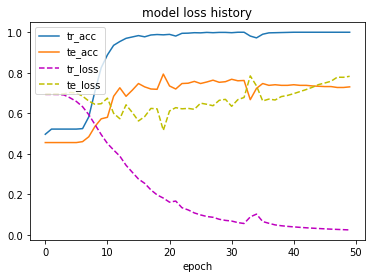

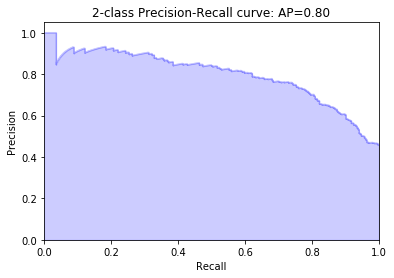

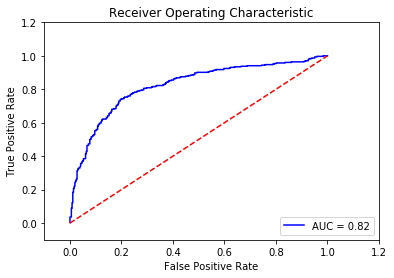

In [38]:
# 4 hidden unit
# tanh activation
# maxlen=100

model_plot(model, X_train_hot, y_train, X_test_hot, y_test)

Predict...
Predict completed...
--Accuracy--
Train:	0.99925 
Test:	0.74963 
             precision    recall  f1-score   support

        0.0       0.84      0.67      0.75       363
        1.0       0.68      0.84      0.75       304

avg / total       0.77      0.75      0.75       667

--epoch on val loss--
26
0.502885763881
--acc--
0.773613194565


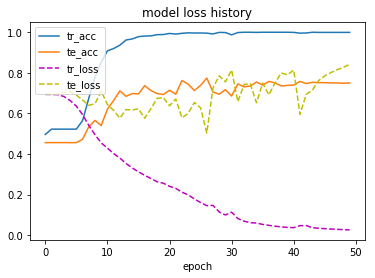

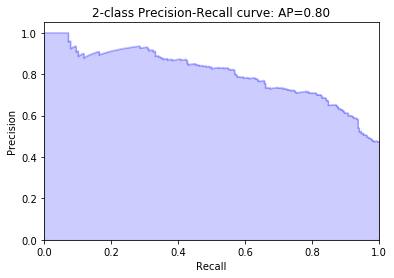

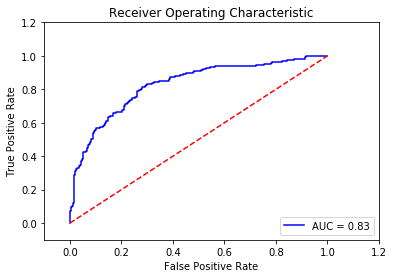

In [29]:
# 5 hidden unit
# tanh activation
# maxlen=100

model_plot(model, X_train_hot, y_train, X_test_hot, y_test)

### Maxlen = 50

Predict...
Predict completed...
--Accuracy--
Train:	0.99775 
Test:	0.72264 
             precision    recall  f1-score   support

        0.0       0.84      0.61      0.70       363
        1.0       0.65      0.86      0.74       304

avg / total       0.75      0.72      0.72       667

--epoch on val loss--
30
0.545426535642
--acc--
0.763118441316


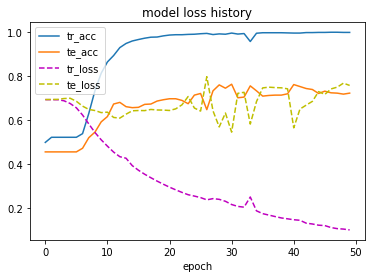

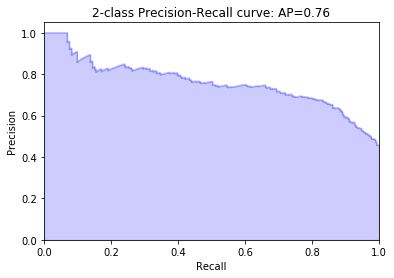

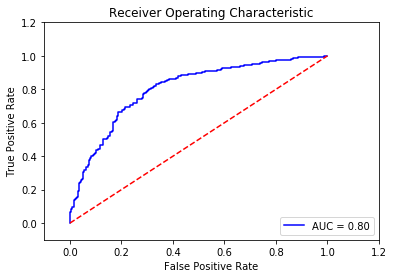

In [43]:
# 5 hidden unit
# tanh activation
# maxlen=50
# pre truncate

model_plot(model, X_train_hot, y_train, X_test_hot, y_test)

In [ ]:
# 5 hidden unit
# tanh activation
# maxlen=50
# pre truncate

model_plot(model, X_train_hot, y_train, X_test_hot, y_test)

In [21]:
hist_stack = np.vstack((hist.history['loss'],hist.history['acc'],hist.history['val_loss'],hist.history['val_acc']))
for i in range(hist_stack.shape[1]):
    print("%f\t%f\t%f\t%f" %(hist_stack[0, i],hist_stack[1, i],hist_stack[2, i],hist_stack[3, i]))

0.693120	0.495874	0.693477	0.455772
0.692886	0.522131	0.693926	0.455772
0.692055	0.522131	0.694401	0.455772
0.682687	0.522131	0.702691	0.455772
0.662807	0.522131	0.707154	0.455772
0.635458	0.522131	0.689414	0.455772
0.593331	0.564141	0.664713	0.472264
0.540315	0.673668	0.639132	0.532234
0.494255	0.777944	0.645087	0.565217
0.454335	0.854464	0.714091	0.539730
0.430167	0.909977	0.634990	0.623688
0.404307	0.912978	0.605161	0.673163
0.374369	0.942236	0.600728	0.689655
0.350594	0.959490	0.616670	0.686657
0.329416	0.970743	0.643851	0.670165
0.311564	0.975994	0.642765	0.689655
0.295460	0.978995	0.642966	0.695652
0.283713	0.988747	0.599989	0.725637
0.266445	0.986497	0.618129	0.710645
0.251981	0.990248	0.593731	0.730135
0.240102	0.990248	0.558492	0.758621
0.225313	0.993248	0.689260	0.694153
0.210695	0.995499	0.702146	0.695652
0.272351	0.957239	0.750983	0.668666
0.199457	0.989497	0.662704	0.703148
0.172375	0.996249	0.716505	0.703148
0.154886	0.996999	0.643424	0.746627
0.135086	0.999250	0.735533	0

In [25]:
def model_plot(model, X_train_hot, y_tr, X_test_hot, y_te, random_state=42):
    from sklearn.metrics import precision_recall_curve
    import matplotlib.pyplot as plt
    from sklearn.metrics import average_precision_score
    from sklearn.metrics import roc_curve, auc
    from sklearn.metrics import classification_report

    print('Predict...')
    y_pred_train = model.predict(X_train_hot)
    y_pred_test = model.predict(X_test_hot)
    print('Predict completed...')
    
    y_pred_tr = []
    y_pred_te = []

    for pred in y_pred_train:
        if pred > 0.5:
            y_pred_tr.append(1)
        else:
            y_pred_tr.append(0)
        
    for pred in y_pred_test:
        if pred > 0.5:
            y_pred_te.append(1)
        else:
            y_pred_te.append(0)

        
    print('--Accuracy--')   
    print('Train:\t%.5f ' %(np.sum(y_tr == y_pred_tr)/len(y_pred_tr)))
    print('Test:\t%.5f ' %(np.sum(y_te == y_pred_te)/len(y_pred_te)))
    
    print(classification_report(y_te,y_pred_te))
    
    n_epoch = np.argmin(hist.history['val_loss'])
    print('--epoch on val loss--')
    print(n_epoch)
    print(hist.history['val_loss'][n_epoch])
    print('--acc--')
    print(hist.history['val_acc'][n_epoch])
    
    plt.plot(hist.history['acc'])
    plt.plot(hist.history['val_acc'])
    plt.plot(hist.history['loss'], 'm--')
    plt.plot(hist.history['val_loss'], 'y--')
    plt.title('model loss history')
    plt.xlabel('epoch')
    plt.legend(['tr_acc', 'te_acc','tr_loss', 'te_loss'], loc='upper left')
    plt.show()
    plt.clf()
    
    precision, recall, _ = precision_recall_curve(y_te, y_pred_test)
    average_precision = average_precision_score(y_te, y_pred_test)
    
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
    plt.show()
    plt.clf()
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_te, y_pred_test)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, 'b',
    label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.2])
    plt.ylim([-0.1,1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [24]:
# x_train, x_test, y_train, y_test = load_data()

In [25]:
# from sklearn.cross_validation import StratifiedKFold

# def train_and_evaluate_model(model, data[train], labels[train], data[test], labels[test)):
#     model.fit...
#     # fit and evaluate here.

# if __name__ == "__main__":
#     n_folds = 10
#     data, labels, header_info = load_data()
#     skf = StratifiedKFold(labels, n_folds=n_folds, shuffle=True)

#     for i, (train, test) in enumerate(skf):
#             print "Running Fold", i+1, "/", n_folds
#             model = None # Clearing the NN.
#             model = create_model()
#             train_and_evaluate_model(model, data[train], labels[train], data[test], labels[test])